# A tutorial for running a debris flow simulation

This tutorial is written as a Jupyter notebook and provides a step-by-step tutorial for setting up a debris flow model and plot its outputs. We will use the sample data included in the synxflow package. The notebook can be downloaded from [Github](https://github.com/SynxFlow/SynxFlow/blob/master/docs/source/Tutorials/debris.ipynb).

[![Run a debris model](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1xz-CqSVJBH_nyFZSRVagRVHZ2dcXiFI-?usp=sharing)

Authors: 
[Xilin Xia](https://www.birmingham.ac.uk/staff/profiles/civil/xia-xilin.aspx), 
[Kristine Jarsve](https://www.linkedin.com/in/kristine-thorkildsen-jarsve/)

Date: 03/10/2023

## Explaining the data

The first step is to list which data is included in the sample.

In [1]:
from synxflow import IO
import os
from synxflow.IO.demo_functions import get_sample_data
dem_file, demo_data, data_path = get_sample_data(case_type ='debris') # get the path of sample data
os.listdir(data_path)

['Erosion.txt', 'DEM.txt']

As we can see from the list, there are 2 files in the folder. Both of them are ArcGIS ASCII format raster. 'DEM.txt' defines the topography while 'Erosion.txt' defines the erodible depth.

 We can use the 'Raster' and 'mapshow' functions built in synxflow to visualise them. As we can see from the figure, the DEM represents a channel joining a floodboard. The erodible depth represents some material along the channel.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

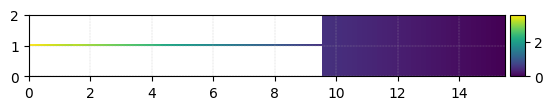

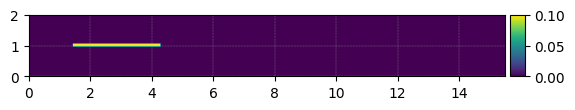

In [2]:
DEM = IO.Raster(os.path.join(data_path,'DEM.txt')) # load the file into a Raster object
DEM.mapshow() # plot the Raster object
ERO = IO.Raster(os.path.join(data_path,'Erosion.txt')) # load the file into a Raster object
ERO.mapshow() # plot the Raster object

## Generating the inputs and runing the simulation

We will now use the data we have just loaded to set up a flood model. In the first step, we need to initialise an InputModel object with the DEM. We also want to specify the directory where the simulation is run and the number of devices we want to use. The debris flow solver only supports single GPU now.

In [3]:
case_folder = os.path.join(os.getcwd(), 'debris_case') # define a case folder in the current directory
case_input = IO.InputModel(DEM, num_of_sections=1, case_folder=case_folder)

We can then put some water in the catchment by setting an initial depth. In our case, the initial water depth is 0 m across the catchment.

In [4]:
case_input.set_initial_condition('h0', 0.0)

We then need to define a few additional parameters needed for debris flow simulations. In this situation, we used the 'add_user_defined_parameter' function.

In [7]:
import numpy as np
concentration = np.zeros(DEM.array.shape)
array = ERO.array + 0
array[np.isnan(array)] = 0
erodible_depth = array 
static_friction = np.zeros(DEM.array.shape) + 0.62
dynamic_friction = np.zeros(DEM.array.shape) + 0.44

case_input.add_user_defined_parameter('C', concentration)
case_input.add_user_defined_parameter('erodible_depth', erodible_depth)
case_input.add_user_defined_parameter('static_friction_coeff', static_friction)
case_input.add_user_defined_parameter('dynamic_friction_coeff', dynamic_friction)
case_input.set_grid_parameter(manning=0.018)

C is added to the InputModel object
erodible_depth is added to the InputModel object
static_friction_coeff is added to the InputModel object
dynamic_friction_coeff is added to the InputModel object


We then need to define the locations for flow gauge. We have defined four gauges at the inlet of the channel and another four at the outlet.

In [8]:
case_input.set_gauges_position(np.array([[0.5, 0.95],
                                        [0.5,0.975],
                                        [0.5,1.0],
                                        [0.5,1.025],
                                        [8.5,0.95],
                                        [8.5,0.975],
                                        [8.5,1.0],
                                        [8.5,1.025]]))

The next step is setting up the boundary conditions similar to the flood simulation.

Flow series on boundary 1 is converted to velocities
Theta = 0.00degree
Flow series on boundary 2 is converted to velocities
Theta = 270.00degree


(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'Domain Map'}>)

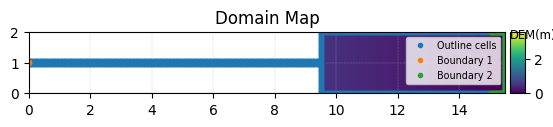

In [11]:
flux = 600/10**6 # Flux given in cm^3/s. This converts the flux to m^3
time = 20
C_in = 0.05

sourceBoundary = np.array([[-0.025,1.025], [0.025,0.975]]) # define the boundary box at the inlet
outBoundary = np.array([[15,0], [16,2]]) #define the boundary box at the outlet
discharge_values = np.array([[0,flux],[time,flux],[time+0.1,0]])
concentration_values = np.array([[0,C_in],[time,C_in],[time+0.1,0]]) 
hUh_out = np.array([[0,0],[1,0]])

bound_list = [{'polyPoints': sourceBoundary, 'type': 'open', 'hU': discharge_values, 'C': concentration_values},
              { 'polyPoints': outBoundary, 'type': 'open', 'hU': hUh_out, 'h': hUh_out}]

case_input.set_boundary_condition(boundary_list = bound_list, outline_boundary = 'rigid')
case_input.domain_show()

We can now set up the running time and generate the input files for the solver, similar to setting up the flood simulation.

In [12]:
case_input.set_runtime([0, 60, 10, 10])
print(case_input)

case_input.get_data_folders()
case_input.write_input_files()

---------------------- Model information ---------------------
case_folder : /mnt/d/Projects/synxflow-newbc/SynxFlow/docs/source/Tutorials/debris_case
birthday : 2024-08-30 23:11
num_GPU : 1
run_time : [0, 60, 10, 10]
num_gauges : 8
---------------------- Grid information ----------------------
area : [np.float64(12.950000000000003), 'm^2']
shape : (80, 620)
cellsize : [0.025, 'm']
num_cells : 20720
extent : {'left': 0.0, 'right': 15.5, 'bottom': 0.0, 'top': 2.0}
---------------------- Initial condition ---------------------
h0 : 0.0
hU0x : 0
hU0y : 0
---------------------- Boundary condition --------------------
num_boundary : 3
boundary_details : ['0. (outline) rigid, number of cells: 1394', '1. open, hU given, C given, number of cells: 2', '2. open, h given, hU given, number of cells: 118']
---------------------- Rainfall ------------------------------
num_source : 1
max : [np.int64(0), 'mm/h']
sum : [np.float64(0.0), 'mm']
average : [np.float64(0.0), 'mm/h']
spatial_res : [np.float

We still need define a few other parameters such as the densities and particle diameter. These parameters need to be written into a 'parameters.dat' file.

In [13]:
rhoW = 1000 #Water density, [kg/m3]
rhoS = 2650 #Solids density, [kg/m3]
particleD = 0.00308 #Particle diameter, [m]
phi = 0.4 #Porosity
criticalSlope = 1.0
alpha = 1.0
beta = 0.01

paramFile = os.path.join(case_folder,'input/parameters.dat')
print(paramFile)

f = open(paramFile,'w')
f.write(str(rhoW))
f.write(' ')
f.write(str(rhoS))
f.write(' ')
f.write(str(particleD))
f.write(' ')
f.write(str(phi))
f.write(' ')
f.write(str(criticalSlope))
f.write(' ')
f.write(str(alpha))
f.write(' ')
f.write(str(beta))
f.close()

/mnt/d/Projects/synxflow-newbc/SynxFlow/docs/source/Tutorials/debris_case/input/parameters.dat


Now we can run the simulation. Please note that currently the debris flow solver only supports single GPU.

In [14]:
from synxflow import debris
debris.run(case_folder)

GPU 0 is choosen as the model device
Current time: 0s
Total time: 60s
Output time interval: 10s
Backup interval: 10s
Read in mesh successfully
Read in field successfully
0
0.005000
0.006741
...
59.885380
59.900757
59.916134
59.931511
59.946888
59.962265
59.977642
59.993019
60.000000
Writing output files
Writing backup files
Total runtime 17692.6ms


## Plotting the results

After the simulation finishes, we can plot the discharge at both the inlet and the outlet of the channel. To calculate the total discharge, we have to add the unit-width discharges (hU) from all the four gauges together and multiply it with the cell width.

<function matplotlib.pyplot.show(close=None, block=None)>

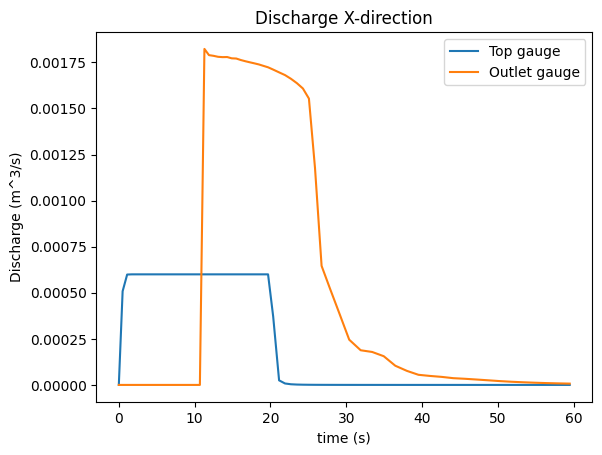

In [15]:
import matplotlib.pyplot as plt

case_output = IO.OutputModel(case_folder=case_folder) #Creating an output object



# Calculate the discharge
hU_gauges_pos, hU_times, hU_values = case_output.read_gauges_file(file_tag = 'hU')
hUx_values = hU_values[0] # Extracts the x-values from the 3D array to a 2D array
hUy_values = hU_values[1]  # Extracts the y-values from the 3D array to a 2D array

cellsize = DEM.cellsize
hUx_top = hUx_values[:,0:4]
hUx_outlet = hUx_values[:,4:8]  
hUy_top = hUy_values[:,0:4]
hUy_outlet = hUy_values[:,4:8] 
dis_hUy_top = np.abs(np.sum(hUy_top, axis = 1)*cellsize)
dis_hUy_outlet = np.abs(np.sum(hUy_outlet, axis = 1)*cellsize)

dis_hUx_top = np.abs(np.sum(hUx_top, axis = 1)*cellsize)
dis_hUx_outlet = np.abs(np.sum(hUx_outlet, axis = 1)*cellsize)


plt.figure(0)
plt.plot(hU_times,dis_hUx_top)
plt.plot(hU_times,dis_hUx_outlet)
plt.legend(['Top gauge', 'Outlet gauge'])
plt.xlabel('time (s)')
plt.ylabel('Discharge (m^3/s)')
plt.title('Discharge X-direction')
plt.show
